In [10]:
import numpy as np
import os
import root_numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
%matplotlib inline

In [3]:
eval = pd.read_csv('/notebooks/data/samples_for_comparison/sample_test.csv')

part_codes = {'Ghost':0, 'Electron':11, 'Muon':13, 'Pion':211, 'Kaon':321, 'Proton':2212}

eval_types = np.abs(eval['MCParticleType'])

mc_features = ['Unnamed: 0', 'HasMC', 'MCParticleType', 'MCParticleP', 'MCParticlePt', 'MCVirtualMass', 
               'MCFromB', 'MCFromD', 'MCVertexType', 'MCVertexX', 'MCVertexY', 'MCVertexZ', 
               'piplus_OWNPV_X', 'piplus_OWNPV_Y', 'piplus_OWNPV_Z', 'piplus_OWNPV_XERR', 
               'piplus_OWNPV_YERR', 'piplus_OWNPV_ZERR', 'piplus_OWNPV_CHI2', 'piplus_OWNPV_NDOF', 
               'piplus_IP_OWNPV', 'piplus_IPCHI2_OWNPV', 'nCandidate', 'totCandidates', 'EventInSequence', 
               'TrackHistory', 'TrackType', 'RecoPIDcode']

constant_features = ['TrackMatchChi2', 'TrackCloneDist', 'RichUsedAero']

eval.drop(mc_features + constant_features, axis=1, inplace=1)
print eval.shape

config_path = '/notebooks/data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/'
def get_features_for(part_type):
    config_file_name = 'GlobalPID_{0}_Long_ANN.txt'.format(part_type)
    config = np.loadtxt(os.path.join(config_path, config_file_name), dtype='S', comments='#')
    return config[5:]

(100000, 77)


In [11]:
import cPickle as pickle
from sklearn.metrics import roc_curve, roc_auc_score

def test_model(model_type, part_type):
    model = pickle.load(open('models/{0}-{1}.pkl'.format(model_type, part_type), 'rb'))
    
    preds = model.predict_proba(eval)
    true_labels = (eval_types == part_codes[part_type]).astype(int)
    roc_auc = roc_auc_score(true_labels, preds[:, 1])
    fpr, tpr, _ = roc_curve(true_labels, preds[:, 1])

    result = {}
    result[part_type] = roc_auc, fpr, tpr

    for other_part in part_codes:
        if other_part == part_type:
            continue
        mask = (eval_types == part_codes[other_part]) | (eval_types == part_codes[part_type])
        X = eval[mask]
        true_labels = (eval_types[mask].values == part_codes[part_type]).astype(int)
        preds = model.predict_proba(X)
        result[other_part] = roc_auc_score(true_labels, preds[:, 1])

    return result

    
# rocs_kmlp = {}
# for part_type in part_codes:
#     print part_type
#     rocs_kmlp[part_type] = test_model('kMLP', part_type)
    
rocs_kbdt = {}
for part_type in part_codes:
    print part_type
    rocs_kbdt[part_type] = test_model('kBDT', part_type)
print 'Done!'

Ghost
Muon
Pion
Kaon
Proton
Electron
Done!


In [5]:
plist = ['Electron', 'Pion', 'Kaon', 'Muon', 'Ghost', 'Proton']

def plot_auc(rocs, model_name):
    plt.figure(figsize=(12, 8))
    for part_type in plist:
        label = '{0}, {1:0.3f}'.format(part_type, rocs[part_type][part_type][0])
        plt.plot(rocs[part_type][part_type][1], rocs[part_type][part_type][2], label=label)
    plt.legend(loc=0, prop={'size':20})
    plt.title('ROC AUC for {0}'.format(model_name))
    
def plot_binary_rocs(rocs, model_name):
    binary_rocs = np.zeros(shape=(6, 6))
    for index, part_type in enumerate(plist):
        for jndex, other_part in enumerate(plist):
            if index == jndex:
                binary_rocs[index, index] = 1.0
            else:
                binary_rocs[index, jndex] = rocs[part_type][other_part]
                binary_rocs[jndex, index] = rocs[other_part][part_type]
    plt.figure(figsize=(10, 8))
    sns.heatmap(binary_rocs, cmap='RdBu_r', xticklabels=plist, yticklabels=plist, annot=True, fmt='.3f')
    plt.title('Pairwise AUC for {0}'.format(model_name))

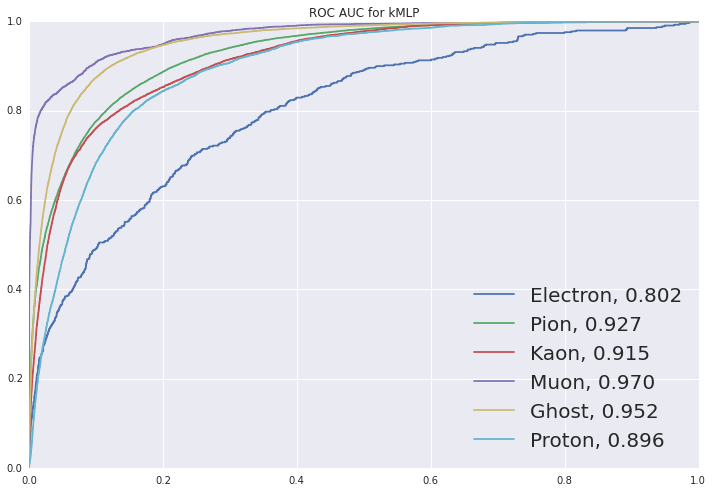

In [6]:
plot_auc(rocs_kmlp, 'kMLP')

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


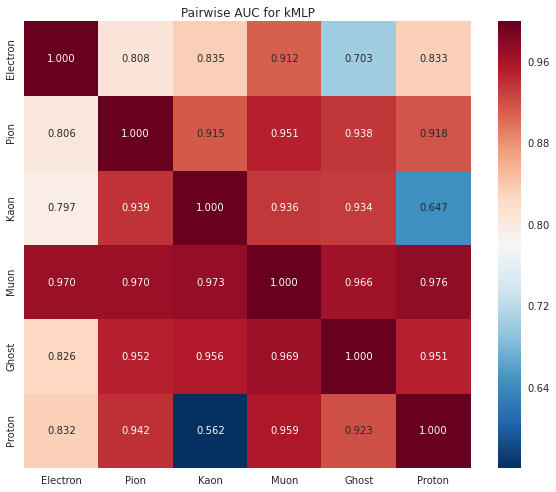

In [7]:
plot_binary_rocs(rocs_kmlp, 'kMLP')

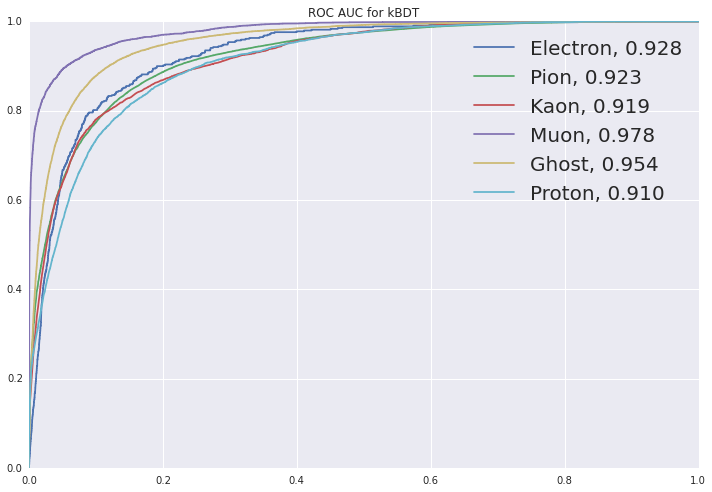

In [12]:
plot_auc(rocs_kbdt, 'kBDT')

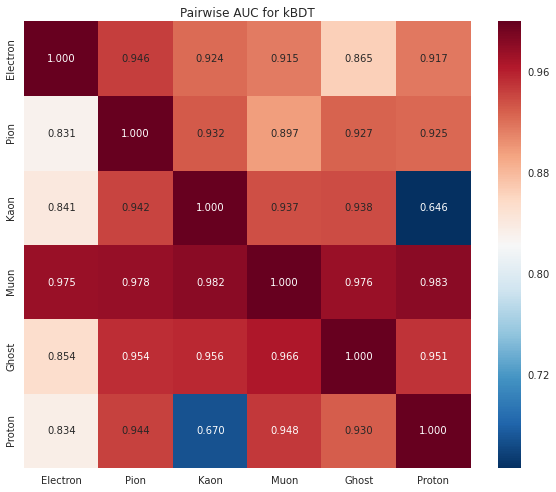

In [13]:
plot_binary_rocs(rocs_kbdt, 'kBDT')

In [19]:
def predictions_for_model(model_name):
    print 'Probas for {0}'.format(model_name)
    for part_name in part_codes.keys():
        model = pickle.load(open('models/{0}-{1}.pkl'.format(model_name, part_name), 'rb'))
        preds = model.predict_proba(eval.iloc[:10])
        print part_name
        print preds

In [20]:
predictions_for_model('kMLP')

Probas for kMLP
Ghost
[[ 0.43822611  0.56177389]
 [ 0.44613152  0.55386848]
 [ 0.3611995   0.6388005 ]
 [ 0.49565296  0.50434704]
 [ 0.30297177  0.69702823]
 [ 0.4883218   0.5116782 ]
 [ 0.49531155  0.50468845]
 [ 0.16762502  0.83237498]
 [ 0.21857934  0.78142066]
 [ 0.48264937  0.51735063]]
Muon
[[ 0.45471478  0.54528522]
 [ 0.36916302  0.63083698]
 [ 0.44995854  0.55004146]
 [ 0.46182652  0.53817348]
 [ 0.21202588  0.78797412]
 [ 0.25334091  0.74665909]
 [ 0.4799131   0.5200869 ]
 [ 0.15957785  0.84042215]
 [ 0.38942083  0.61057917]
 [ 0.49870233  0.50129767]]
Pion
[[ 0.18231598  0.81768402]
 [ 0.16150767  0.83849233]
 [ 0.00699304  0.99300696]
 [ 0.00673039  0.99326961]
 [ 0.34944924  0.65055076]
 [ 0.0547273   0.9452727 ]
 [ 0.01013389  0.98986611]
 [ 0.35015658  0.64984342]
 [ 0.26931037  0.73068963]
 [ 0.2298468   0.7701532 ]]
Kaon
[[ 0.34013356  0.65986644]
 [ 0.33622057  0.66377943]
 [ 0.49975811  0.50024189]
 [ 0.49833007  0.50166993]
 [ 0.40033734  0.59966266]
 [ 0.41448717  

In [21]:
predictions_for_model('kBDT')

Probas for kBDT
Ghost
[[ 0.70479058  0.29520942]
 [ 0.65433362  0.34566638]
 [ 0.47004925  0.52995075]
 [ 0.85255483  0.14744517]
 [ 0.41375226  0.58624774]
 [ 0.85369166  0.14630834]
 [ 0.90943336  0.09056664]
 [ 0.44574277  0.55425723]
 [ 0.33360151  0.66639849]
 [ 0.7881202   0.2118798 ]]
Muon
[[ 0.73217153  0.26782847]
 [ 0.50854037  0.49145963]
 [ 0.75608761  0.24391239]
 [ 0.8045901   0.1954099 ]
 [ 0.40840454  0.59159546]
 [ 0.50222537  0.49777463]
 [ 0.84972035  0.15027965]
 [ 0.39611038  0.60388962]
 [ 0.46431126  0.53568874]
 [ 0.58471837  0.41528163]]
Pion
[[ 0.44392098  0.55607902]
 [ 0.36614643  0.63385357]
 [ 0.30371604  0.69628396]
 [ 0.13584493  0.86415507]
 [ 0.46716477  0.53283523]
 [ 0.35294915  0.64705085]
 [ 0.08233337  0.91766663]
 [ 0.48939356  0.51060644]
 [ 0.66669029  0.33330971]
 [ 0.35340784  0.64659216]]
Kaon
[[ 0.53069571  0.46930429]
 [ 0.60513134  0.39486866]
 [ 0.90374071  0.09625929]
 [ 0.87007599  0.12992401]
 [ 0.64400408  0.35599592]
 [ 0.56731797  